# Predict

Use this notebook to train/test models. Using the node system will automatically allow you to cache the trained model for use in the server. Currently the only working model node is named `train_honest_forward`.

In [1]:
# subset expression settings shared between train and test set

subset = dict( 

    random_state = 22, 
    shuffle = True, 
    test_size = 0.2, 
    train_size = 0.8
)

### Train

In [2]:
import nodes
import verbose
verbose.set_level( 0 )

model = nodes.find( "train_honest_forward" ).get_result( 
    
    subset = { ** subset, "type": "train_split" }, 
    length_l = 100,
    lag = 50,
    n_estimators = 100, 
    max_depth = 20,
    max_features = 1.0,
    n_jobs = -1
)

assembling patches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 105361/105361 [00:22<00:00, 4672.92it/s]
training...
{'n_estimators': 100, 'max_depth': 20, 'max_features': 1.0, 'n_jobs': 7}
training estimators: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [24:07<00:00, 96.49s/it]
done


### Validate

In [65]:
import require
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tqdm import tqdm
import sys

n_outcomes = len( require.single( "owid_outcomes" ))
subset_indexing = require.single( "subset_indexing" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

scaler = MinMaxScaler( )
scaler.fit( crop_to_valid_range( nodes.find( "data_for_country" ).get_result( "Germany" ))) # normalize against reference df 

# models should pick up trends
# they need not be super smooth, so smoothing is employed on both time series before scoring
def score( df_true, df_pred ):

    # custom 'variance weighting' equivalent
    scale = lambda df: pd.DataFrame( scaler.transform( df ), columns = df.columns )
    
    df_true = scale( df_true )
    df_pred = scale( df_pred )
    
    r2 = r2_score( df_true.iloc[ :, :n_outcomes ], df_pred.iloc[ :, :n_outcomes ])

     # if r2 is negative, it becomes rather meaningless, so we bound the penalty.
    return max( 0, r2 )

def validate( model, evalset ):
    
    sum = 0
    count = 0
    with tqdm( file = sys.stdout, total = len( evalset ), desc = "evaluation" ) as bar:
    
        for i, point in enumerate( evalset ):
            
            df = point.df
            kwargs = dict( start = 0, callback = lambda p: bar.update( i + p - bar.n ))
            df_pred = model.predict_replace( df, ** kwargs )
        
            assert not df.isna( ).any( ).any( )
            assert not df_pred.isna( ).any( ).any( )
    
            s = score( df, df_pred )
            bar.clear( )
            print( f"r2 in { point.country }: { s :.2f}" )
            sum += s
            count += 1 if s > 0 else 0
    
    avg = sum / len( evalset )
    perc = count / len( evalset )
    print( f"\naverage r2 score: { avg :.2f}\n" )
    print( f"\npercentage with positive r2 score: { perc :.2f}\n" )


trainset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "train_split" })
testset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "test_split" })

print( "test set validation" )
validate( model, testset )


test set validation
r2 in Senegal: 0.00                                                                                                                                      
r2 in Croatia: 0.17                                                                                                                                      
r2 in Italy: 0.47                                                                                                                                        
r2 in Madagascar: 0.00                                                                                                                                   
r2 in Morocco: 0.00                                                                                                                                      
r2 in Malta: 0.15                                                                                                                                        
r2 in Myanmar: 0.00                                     

### Plot

new_deaths_smoothed_per_million in Chile
inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [00:12<00:00, 12.27s/it]


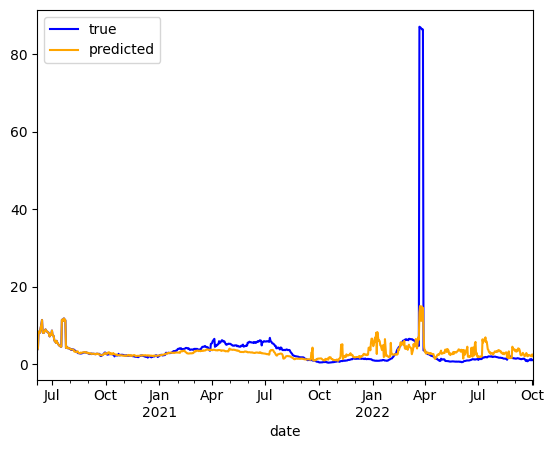

In [72]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import require
import nodes
import verbose
verbose.set_level( 0 )

data_for_country = require.single( "data_for_country" )
subset_indexing = require.single( "subset_indexing" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

trainset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "train_split" })
testset = subset_indexing( nodes.find( "training_data" ).get_result( ), { ** subset, "type": "test_split" })

#country = trainset[ 2 ].country
country = "Chile"
start = 200
length = 800
view_margin = 50
time_range = slice( start - view_margin, start - view_margin + length + view_margin )
column_name = "new_deaths_smoothed_per_million"

df = crop_to_valid_range( data_for_country.get_result( country ))
column = df.columns.tolist( ).index( column_name )
print( f"{ df.columns[ column ]} in { country }" )

with tqdm( file = sys.stdout, total = 1.0, desc = "inference" ) as bar:

    df_pred = model.predict_replace( df, start = start, length = length, callback = lambda p: bar.update( p - bar.n ))

assert not df.isna( ).any( ).any( )
assert not df_pred.isna( ).any( ).any( )

smooth = lambda df: df.rolling( window = 7 ).mean( )

df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )


line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )




In [67]:
" | ".join([ x.country for x in trainset ])

"United Kingdom | Faeroe Islands | Malawi | Canada | Uganda | Bhutan | Nepal | Spain | Peru | Japan | Kuwait | Uruguay | Trinidad and Tobago | Israel | Fiji | Albania | China | Vietnam | Haiti | Namibia | Thailand | Moldova | Turkey | El Salvador | Indonesia | Ghana | Poland | Jamaica | Zimbabwe | Malaysia | Togo | Costa Rica | Mexico | Brazil | Mauritania | Cote d'Ivoire | Suriname | Ecuador | Cyprus | Mozambique | Bahamas | Rwanda | Pakistan | Australia | Nigeria | Bulgaria | Belarus | Ireland | Chile | Liechtenstein | Kazakhstan | Iceland | Kenya | Jordan | Romania | Andorra | Hungary | Mongolia | Iraq | Bolivia | Belize | Panama | Colombia | Serbia | Bahrain | Lithuania | Portugal | Cameroon | Finland | Netherlands | New Zealand | Democratic Republic of Congo | Sri Lanka | United Arab Emirates | Cuba | Azerbaijan | Georgia | Ukraine | Germany | Estonia | France | Tunisia | Paraguay | Guyana | Bosnia and Herzegovina | Cambodia | Puerto Rico | United States Virgin Islands | Russia | 

In [68]:
" | ".join([ x.country for x in testset ])

'Senegal | Croatia | Italy | Madagascar | Morocco | Malta | Myanmar | Denmark | Luxembourg | Argentina | Sweden | Greece | Ethiopia | Dominican Republic | Kosovo | Iran | Belgium | Philippines | South Africa | Laos | Zambia | India | Palestine | Saudi Arabia | Botswana'